## load data

In [2]:
import sys
sys.path.append('./')

In [3]:
import json
import pandas as pd
from mlinterpreter.util import preprocess_data

In [4]:
# 读入数据 和 schema
data_path = "./demo_data/adult.data"
schema_path = "./demo_data/schema.json"
df = pd.read_csv(data_path, header=None)
df.columns = ["age","workclass","fnlwgt","education","education-num","marital-status","occupation","relationship","race","sex",
                 "capital-gain","capital-loss","hours-per-week","native-country","income"]
with open(schema_path, "r") as f:
    schema = json.load(f)

## preprocess data

In [5]:
# 预处理数据
preprocess_df, preprocess_dict = preprocess_data(df=df, schema=schema, process_label=True)

## build  nn model

In [6]:
from mlinterpreter.model.builder import  build_nn

/home/caihengxing/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# 构建 NN 模型， Wide & Deep
# 通过 params 参数修改模型超参数
nnmodel = build_nn(df=preprocess_df, schema=schema)

Epoch 1/10
102/102 [==============================] - 5s 13ms/step - loss: 0.3736 - auc: 0.8630 - val_loss: 0.3123 - val_auc: 0.9112
Epoch 2/10
102/102 [==============================] - 0s 5ms/step - loss: 0.3131 - auc: 0.9102 - val_loss: 0.3065 - val_auc: 0.9159
Epoch 3/10
102/102 [==============================] - 0s 4ms/step - loss: 0.3107 - auc: 0.9117 - val_loss: 0.3025 - val_auc: 0.9166
Epoch 00003: early stopping
Epoch 1/3
128/128 [==============================] - 4s 3ms/step - loss: 0.3584 - auc: 0.8763
Epoch 2/3
128/128 [==============================] - 0s 3ms/step - loss: 0.3109 - auc: 0.9117
Epoch 3/3
128/128 [==============================] - 0s 3ms/step - loss: 0.3076 - auc: 0.9134


## Global surrogate tree

In [9]:
from mlinterpreter.surrogate.global_model import SurrogateTree
# 申明 SurrogateTree
tree = SurrogateTree(params={"max_depth":3})

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  

In [10]:
# fit the SurrogateTree with the model
# return with the R2 value
tree.surrogate(model=nnmodel, df=df, schema=schema, preprocess_dict=preprocess_dict)

0.7636219774671621

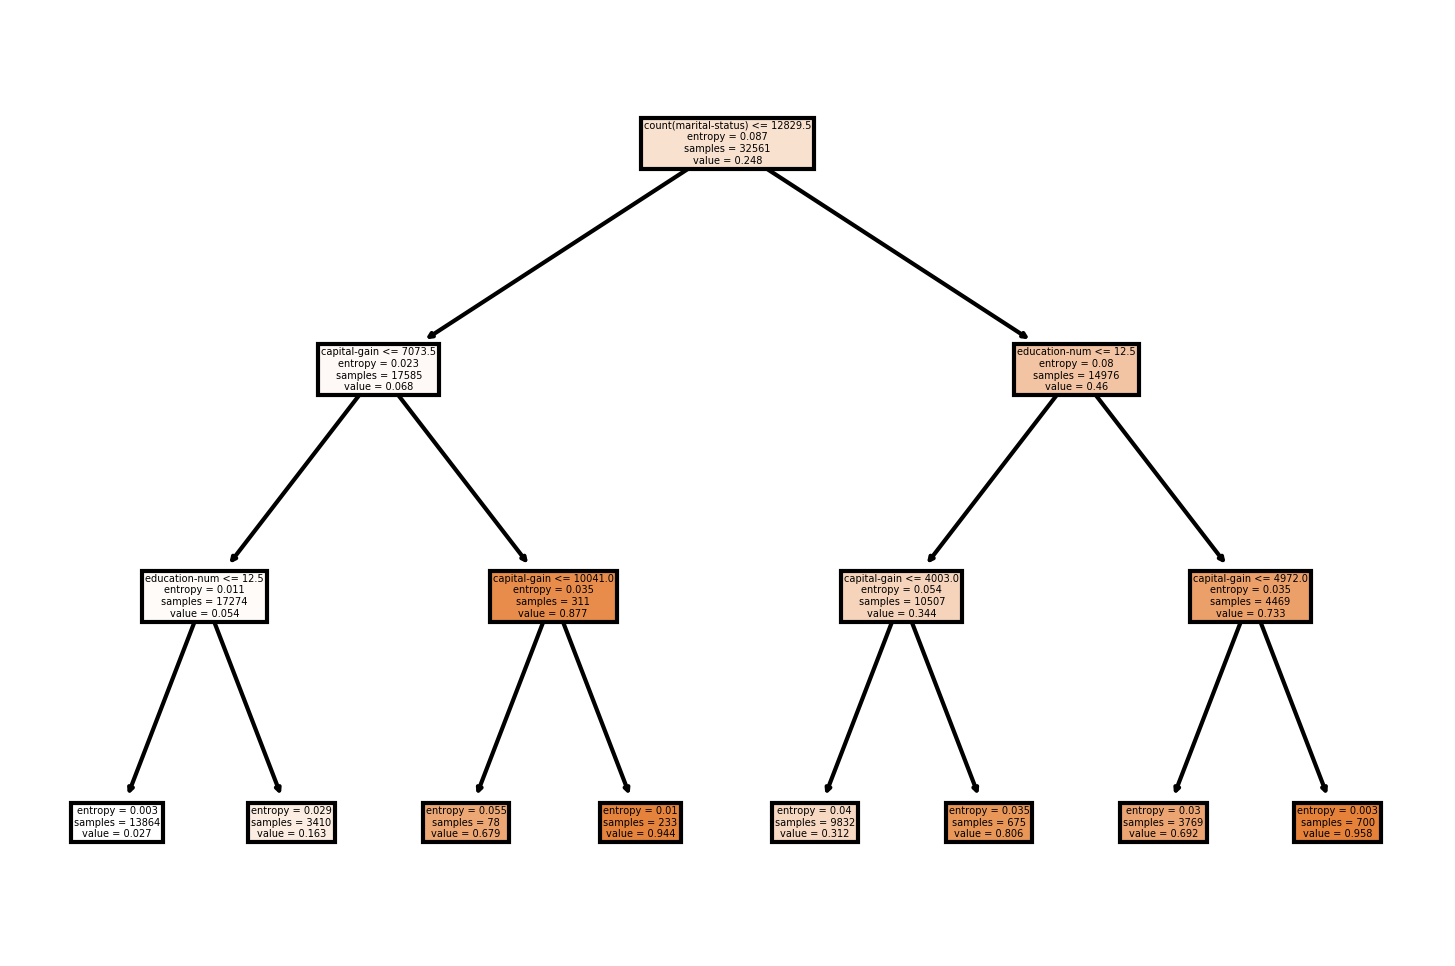

In [11]:
# plot the SurrogateTree
tree.plot_tree()

## LIME for NN

In [12]:
import lime
import lime.lime_tabular
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# 生成解释器
feature_names = [fea['name'] for fea in schema['features'] if fea['name'] != schema['label']]
categorial_features = [fea['name'] for fea in schema['features'] if fea['name'] != schema['label'] and fea['type'] == 'Category']
X = preprocess_df[feature_names]

In [14]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X), feature_names=feature_names, categorical_features=categorial_features,
                                                   class_names=[0,1], discretize_continuous=True)


In [15]:
def f(X):
    res = nnmodel.predict([X[:, i] for i in range(X.shape[1])])
    return np.concatenate([1-res, res], axis=1)

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


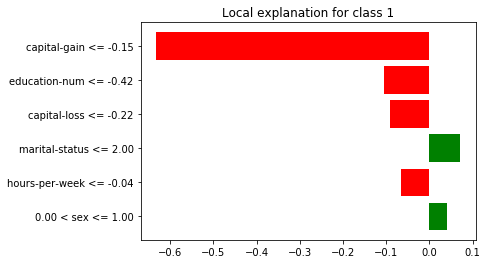

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


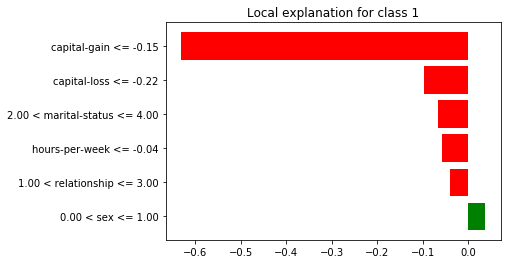

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


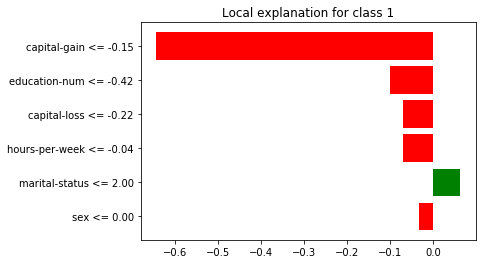

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


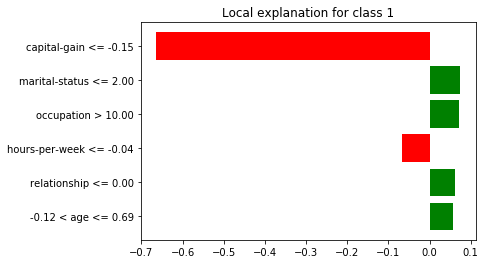

/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/caihengxing/anaconda3/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:56: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


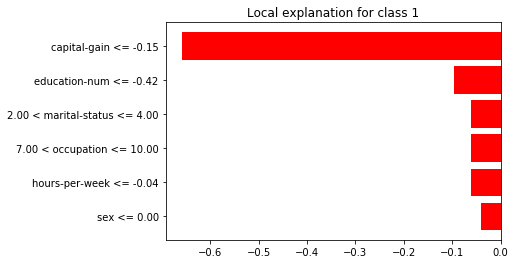

In [16]:
# 对局部点的解释
for _ in range(5):
    i = np.random.randint(0, X.shape[0])
    exp = explainer.explain_instance(np.array(X)[i], f, num_features=6)
    # 显示详细信息图
    exp.show_in_notebook(show_table=True)
    plt.show()
    # 显示权重图
    exp.as_pyplot_figure()
    plt.show()

## SHAP value

In [17]:
from mlinterpreter.shap.shap import ShapInterpreter

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

In [18]:
# 构建 interpreter
# model ： 待解释模型
# background_data: 背景数据
# schema : 数据schmea
# preprocess_dict: 预处理模块
interpreter = ShapInterpreter(model=nnmodel, background_data=preprocess_df.sample(50), schema=schema, preprocess_dict=preprocess_dict)

In [19]:
# select index
positive_index = np.random.choice(preprocess_df[preprocess_df[schema['label']] == 1].index, size=5, replace=False)
negetive_index = np.random.choice(preprocess_df[preprocess_df[schema['label']] == 0].index, size=5, replace=False)

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


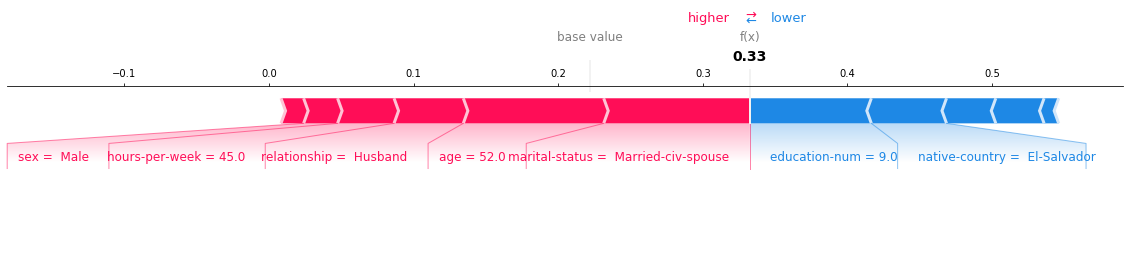

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


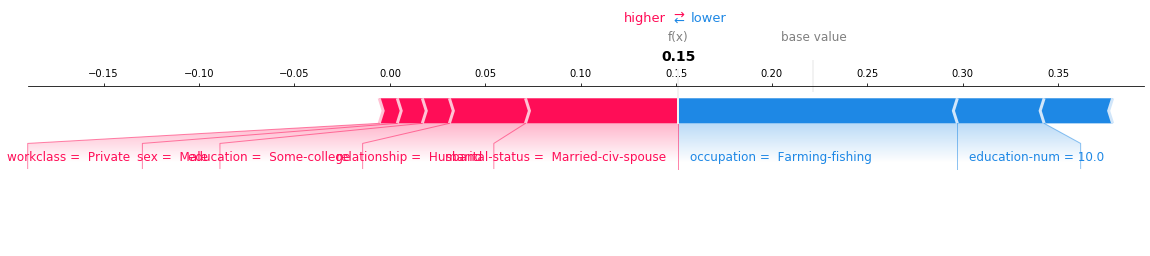

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


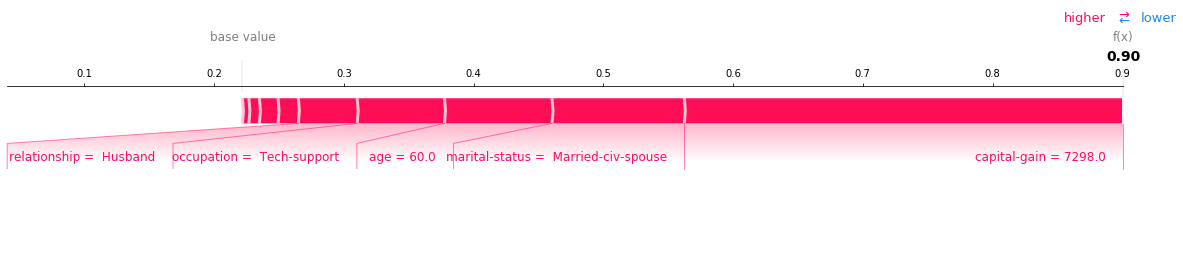

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


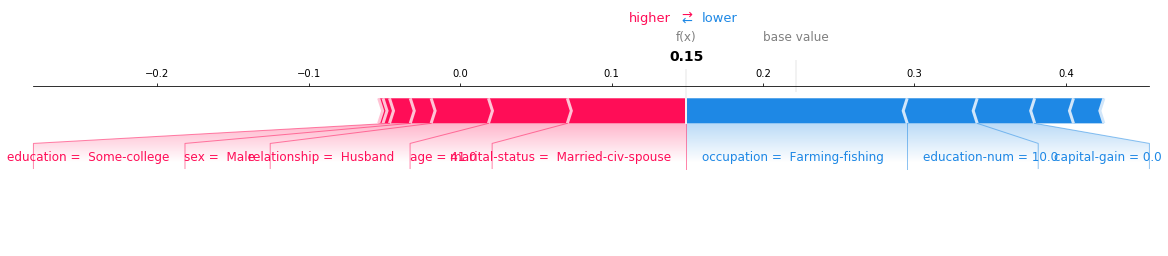

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


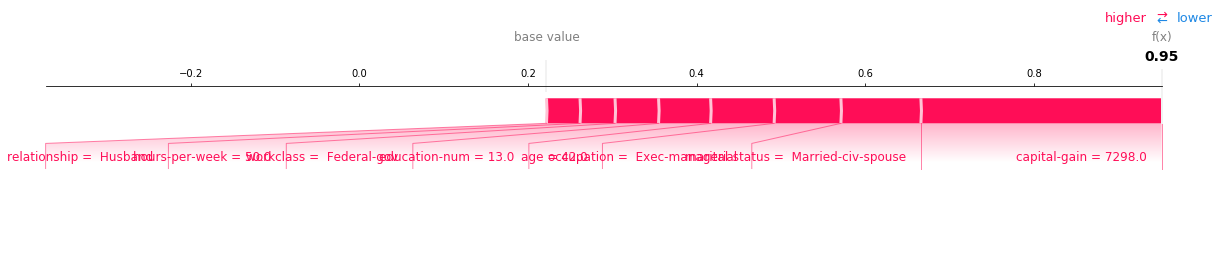

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


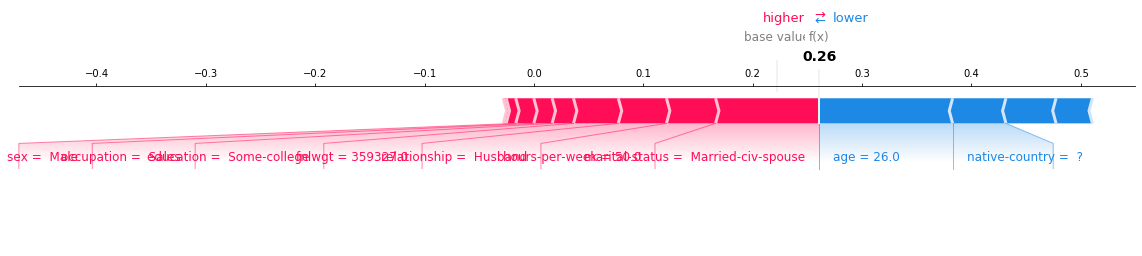

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


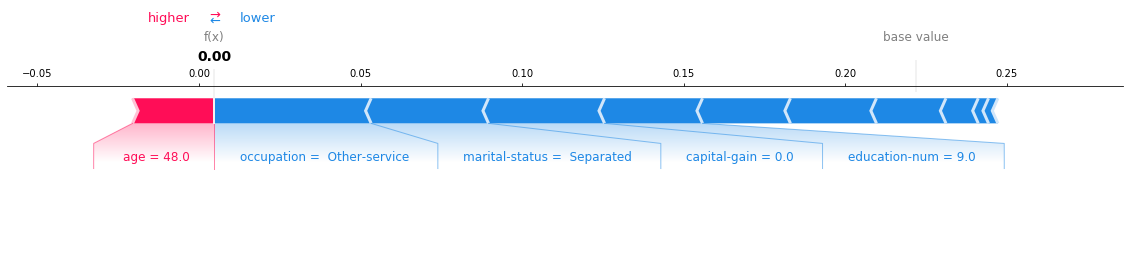

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


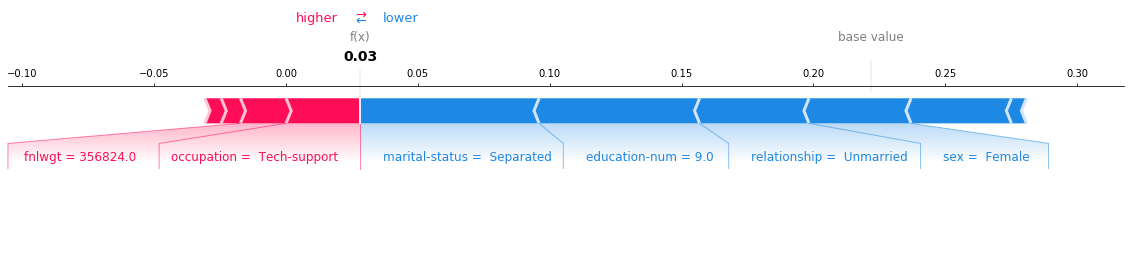

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


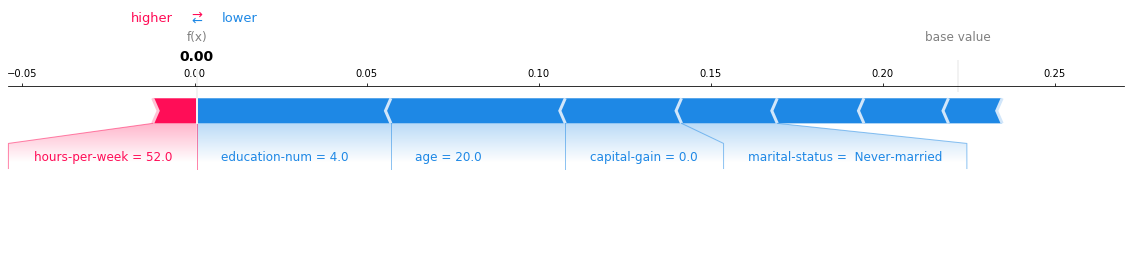

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


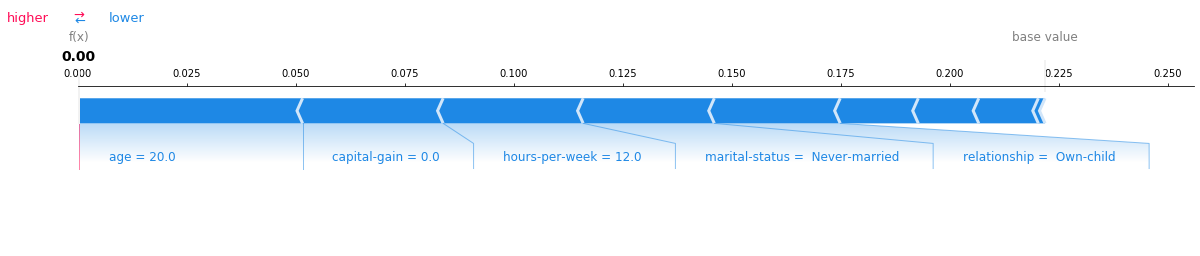

In [20]:
# plot SHAP value for one point
for index in positive_index:
    interpreter.force_plot(df=df.loc[index,:])

# plot SHAP value for one point
for index in negetive_index:
    interpreter.force_plot(df=df.loc[index,:])

  0%|          | 0/10 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

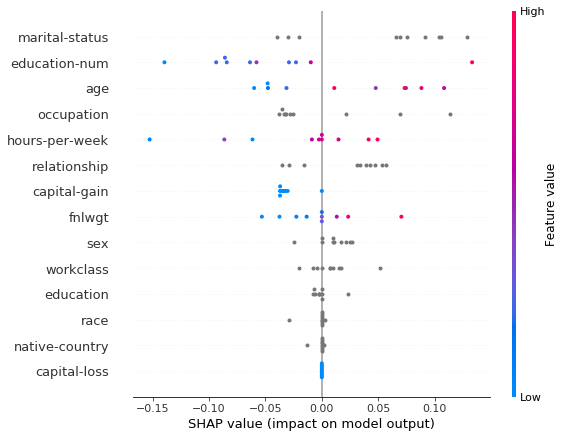

In [21]:
# dot plot summary with several points
# nsample: 在计算SHAP value时用，采样次数
n_points = 10
points_index = np.random.choice(df.index, size=n_points, replace=False)

interpreter.summary_plot(df=df.loc[points_index,:], nsamples=500)

  0%|          | 0/10 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

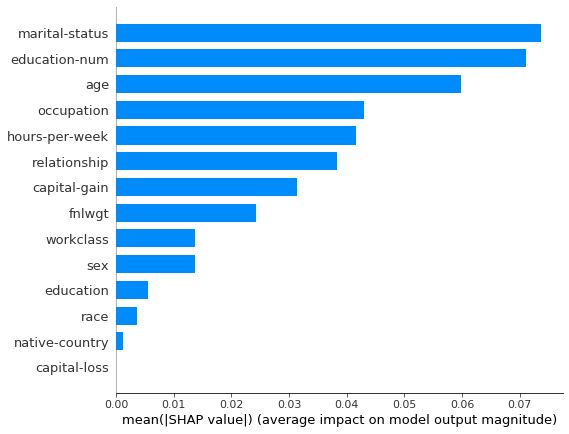

In [22]:
# bar plot summary with several points
# nsample: 在计算SHAP value时用，采样次数
interpreter.summary_plot(df=df.loc[points_index,:], nsamples=500, plot_type='bar')

  0%|          | 0/10 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

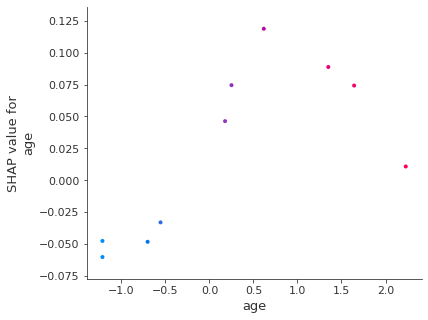

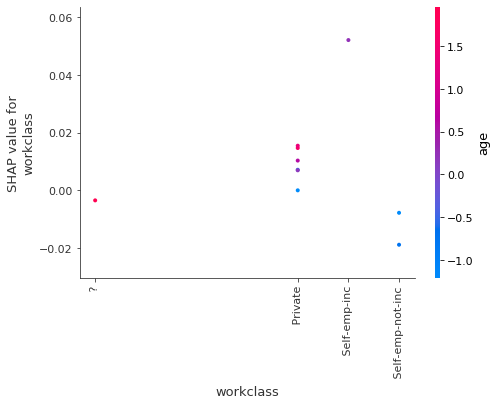

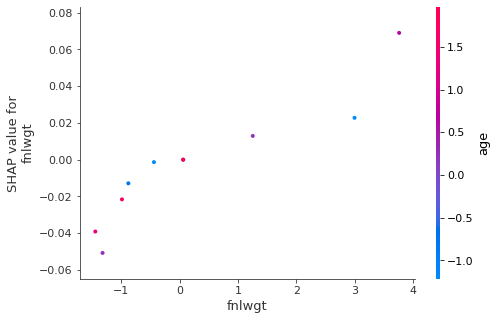

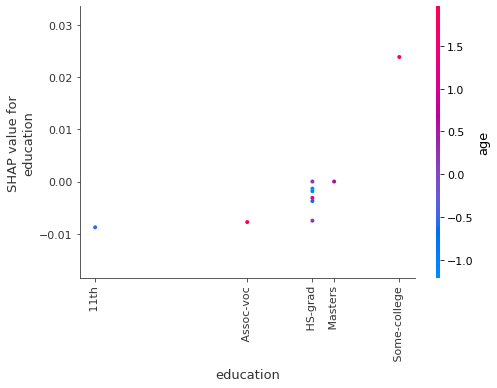

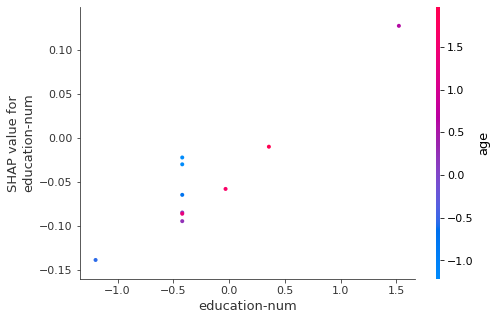

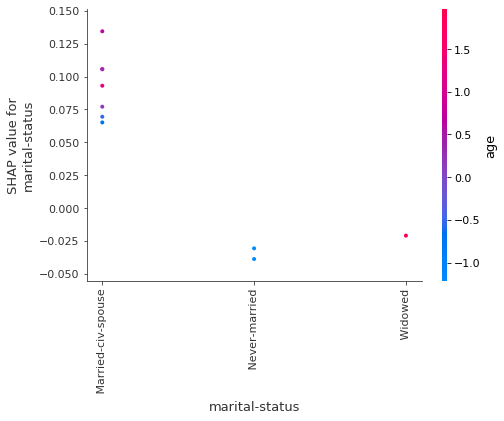

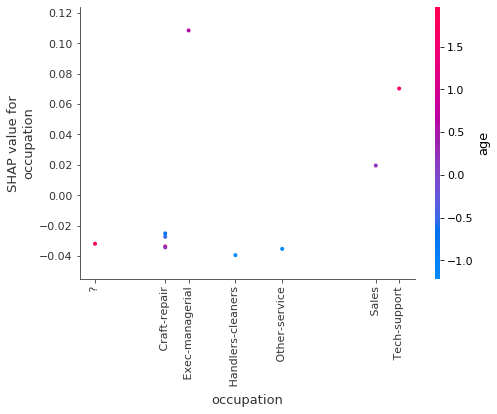

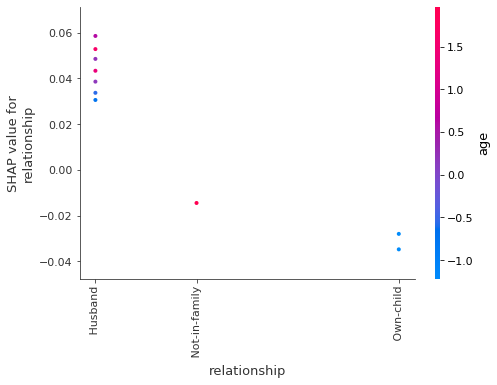

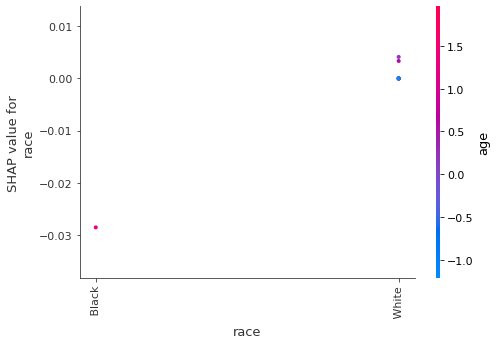

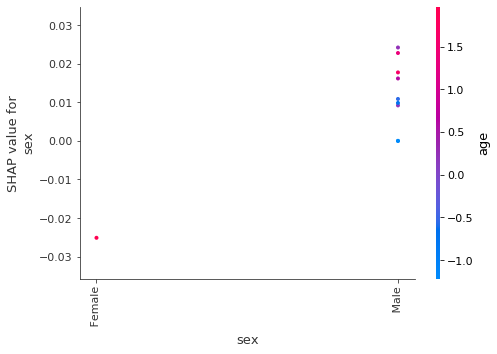

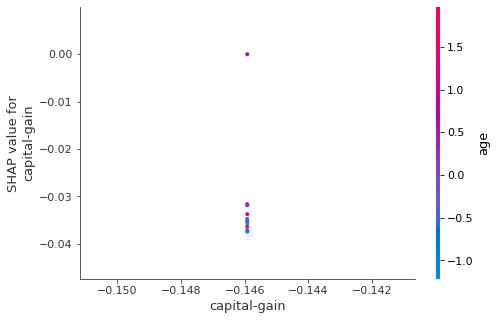

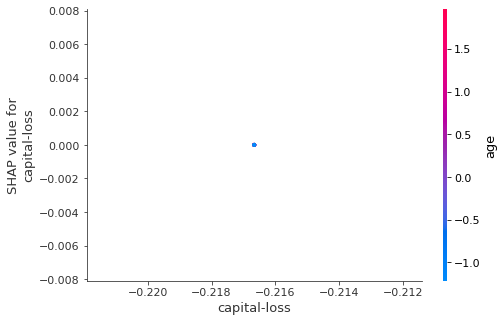

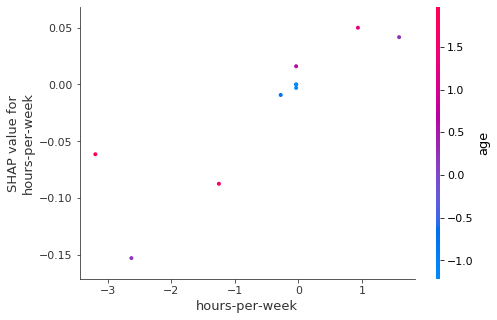

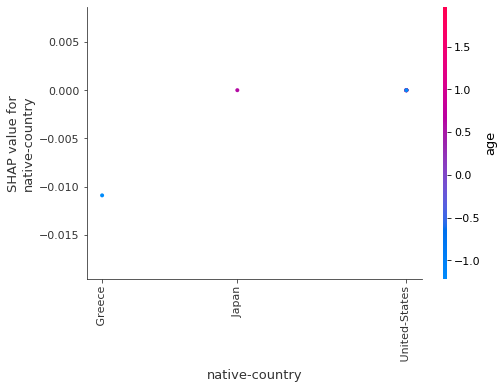

In [23]:
# dependence plot with several points
# nsample: 在计算SHAP value时用，采样次数
# if feature_name is not given, we will plot for all the features
interpreter.dependence_plot(df=df.loc[points_index,:], nsamples=500)

  0%|          | 0/10 [00:00<?, ?it/s]

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To

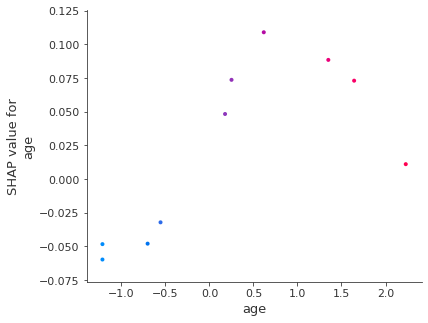

In [24]:
# dependence plot with several points
# nsample: 在计算SHAP value时用，采样次数
# specify a feature
interpreter.dependence_plot(df=df.loc[points_index,:], feature_name='age', nsamples=500)

## Protodash

In [41]:
feature_columns = [col for col in df.columns if col != schema['label']]
label_name = schema['label']
class_names = ['income<50', 'incode>=50']

In [52]:
def predict_classes(model, X, feature_columns=None):
    if isinstance(X, pd.DataFrame):
         return nnmodel.predict([X[k].values for k in feature_columns]) > 0.5
    else:
        return nnmodel.predict([X[:, i] for i in range(X.shape[1])])  > 0.5

def predict_proba(model, X, feature_columns=None):
    if isinstance(X, pd.DataFrame):
        return nnmodel.predict([X[k].values for k in feature_columns])
    else:
        return nnmodel.predict([X[:, i] for i in range(X.shape[1])])

In [64]:
xn_train = preprocess_df[feature_columns]
x_train = df[feature_columns]
p_train = predict_classes(nnmodel, xn_train, feature_columns) # Use trained neural network to predict train points

p_train = p_train.reshape((p_train.shape[0],1))

z_train = np.hstack((xn_train, p_train)) # Store (normalized) instances that were predicted as Good
z_train_good = z_train[z_train[:,-1]==1, :]
df_z_train_good = pd.DataFrame(z_train_good, columns=feature_columns + ['predict'])

zun_train = np.hstack((x_train, p_train)) # Store (unnormalized) instances that were predicted as Good 
zun_train_good = zun_train[zun_train[:,-1]==1, :]
df_zun_train_good = pd.DataFrame(zun_train_good, columns=feature_columns + ['predict'])

In [54]:
from aix360.algorithms.protodash import ProtodashExplainer

In [62]:
idx = np.random.choice(z_train_good.shape[0], size=1) # idx of positive ins

x_selected = z_train_good[idx,:-1]
print("Chosen Sample:", idx)
if predict_proba(nnmodel, x_selected, feature_columns)[0] <= 0.5:
    print("Prediction made by the model:", class_names[0])
else:
    print("Prediction made by the model:", class_names[1])
print("Prediction probabilities:", predict_proba(nnmodel, x_selected, feature_columns)[0])
print("")

# attach the prediction made by the model to X
x_selected = np.hstack((x_selected, predict_classes(nnmodel, x_selected, feature_columns).reshape((1,1))))

Chosen Sample: [1106]
Prediction made by the model: incode>=50
Prediction probabilities: [0.7844995]



In [67]:
df_zun_train_good.iloc[idx[0],:]

age                                47
workclass                   State-gov
fnlwgt                          80914
education                     Masters
education-num                      14
marital-status     Married-civ-spouse
occupation            Exec-managerial
relationship                  Husband
race                            White
sex                              Male
capital-gain                        0
capital-loss                        0
hours-per-week                     47
native-country          United-States
predict                          True
Name: 1106, dtype: object

In [77]:
explainer = ProtodashExplainer()
cand_indexs = np.array([i for i in range(z_train_good.shape[0]) if i != idx[0]])
(W, S, setValues) = explainer.explain(x_selected, z_train_good[cand_indexs, :], m=5)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [78]:
dfs = pd.DataFrame.from_records(zun_train_good[S, 0:-1])
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_good[S[i], -1])]) # Append class names

In [79]:
dfs[dfs.shape[1]+1] = RP
dfs.columns = df_zun_train_good.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

0                    1                    2  \
age                              48                   37                   47   
workclass                   Private         Self-emp-inc            Local-gov   
fnlwgt                       187505               382802                37672   
education              Some-college            Doctorate            Bachelors   
education-num                    10                   16                   13   
marital-status   Married-civ-spouse   Married-civ-spouse   Married-civ-spouse   
occupation                    Sales       Prof-specialty       Prof-specialty   
relationship                Husband              Husband                 Wife   
race                          White                Black                White   
sex                            Male                 Male               Female   
capital-gain                      0                    0                    0   
capital-loss                      0                    0                    0   
hours-per-week                   50                   99                   45   
native-country        United-States        United-States        United-States   
predict                  incode>=50           incode>=50           incode>=50   
Weight                     0.915832            0.0124338           0.00747609   

                                  3                    4  
age                              30                   38  
workclass              Self-emp-inc     Self-emp-not-inc  
fnlwgt                       185384               403391  
education              Some-college            Bachelors  
education-num                    10                   13  
marital-status   Married-civ-spouse   Married-civ-spouse  
occupation          Exec-managerial      Exec-managerial  
relationship                   Wife              Husband  
race                          White                White  
sex                          Female                 Male  
capital-gain                      0                    0  
capital-loss                      0                    0  
hours-per-week                   25                   60  
native-country        United-States        United-States  
predict                  incode>=50           incode>=50  
Weight                   0.00191984            0.0623384

In [80]:
z = z_train_good[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(x_selected[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns =  df_zun_train_good.columns[:-1]
dfw.transpose()

0     1     2     3     4
age             0.86  0.23  1.00  0.08  0.26
workclass       0.38  0.05  0.14  0.05  0.61
fnlwgt          0.46  0.11  0.73  0.47  0.09
education       0.56  0.17  0.42  0.56  0.42
education-num   0.17  0.41  0.64  0.17  0.64
marital-status  1.00  1.00  1.00  1.00  1.00
occupation      0.07  0.26  0.26  1.00  1.00
relationship    1.00  1.00  0.13  0.13  1.00
race            1.00  0.08  1.00  1.00  1.00
sex             1.00  1.00  0.13  0.13  1.00
capital-gain    1.00  1.00  1.00  1.00  1.00
capital-loss    1.00  1.00  1.00  1.00  1.00
hours-per-week  0.88  0.12  0.92  0.41  0.59
native-country  1.00  1.00  1.00  1.00  1.00

In [81]:
z_train_bad = z_train[z_train[:,-1]==0, :] # Store (normalized) instances that were predicted as bad
df_z_train_bad = pd.DataFrame(z_train_bad, columns=feature_columns + ['predict'])
 
zun_train_bad = zun_train[zun_train[:,-1]==0, :] # Store (normalized) instances that were predicted as bad
df_zun_train_bad = pd.DataFrame(zun_train_bad, columns=feature_columns + ['predict'])

In [82]:
idx = np.random.choice(z_train_bad.shape[0], size=1) # idx of positive ins

x_selected = z_train_bad[idx,:-1]
print("Chosen Sample:", idx)
if predict_proba(nnmodel, x_selected, feature_columns)[0] <= 0.5:
    print("Prediction made by the model:", class_names[0])
else:
    print("Prediction made by the model:", class_names[1])
print("Prediction probabilities:", predict_proba(nnmodel, x_selected, feature_columns)[0])
print("")

# attach the prediction made by the model to X
x_selected = np.hstack((x_selected, predict_classes(nnmodel, x_selected, feature_columns).reshape((1,1))))

Chosen Sample: [16331]
Prediction made by the model: income<50
Prediction probabilities: [0.00624478]



In [83]:
df_zun_train_bad.iloc[idx[0],:]

age                           21
workclass                Private
fnlwgt                     43535
education           Some-college
education-num                 10
marital-status     Never-married
occupation                 Sales
relationship       Not-in-family
race                       White
sex                       Female
capital-gain                   0
capital-loss                   0
hours-per-week                40
native-country     United-States
predict                    False
Name: 16331, dtype: object

In [84]:
explainer = ProtodashExplainer()
cand_indexs = np.array([i for i in range(z_train_bad.shape[0]) if i != idx[0]])
(W, S, setValues) = explainer.explain(x_selected, z_train_bad[cand_indexs, :], m=5)

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [85]:
dfs = pd.DataFrame.from_records(zun_train_bad[S, 0:-1])
RP=[]
for i in range(S.shape[0]):
    RP.append(class_names[int(z_train_bad[S[i], -1])]) # Append class names

In [86]:
dfs[dfs.shape[1]+1] = RP
dfs.columns = df_zun_train_bad.columns  
dfs["Weight"] = np.around(W, 5)/np.sum(np.around(W, 5)) # Calculate normalized importance weights
dfs.transpose()

0                    1               2  \
age                         22                   48              29   
workclass              Private              Private         Private   
fnlwgt                   51111               431513          125976   
education         Some-college                 10th         HS-grad   
education-num               10                    6               9   
marital-status   Never-married   Married-civ-spouse       Separated   
occupation               Sales         Craft-repair           Sales   
relationship     Not-in-family              Husband       Unmarried   
race                     White                White           White   
sex                     Female                 Male          Female   
capital-gain                 0                    0               0   
capital-loss                 0                    0               0   
hours-per-week              40                   65              35   
native-country   United-States        United-States   United-States   
predict              income<50            income<50       income<50   
Weight                 0.93764            0.0458095      0.00568657   

                                  3                  4  
age                              27                 27  
workclass                   Private            Private  
fnlwgt                        44767              38918  
education                   HS-grad            HS-grad  
education-num                     9                  9  
marital-status   Married-civ-spouse      Never-married  
occupation          Farming-fishing   Transport-moving  
relationship                Husband      Not-in-family  
race                          White              White  
sex                            Male               Male  
capital-gain                      0                  0  
capital-loss                      0               1876  
hours-per-week                   40                 75  
native-country        United-States      United-States  
predict                   income<50          income<50  
Weight                   0.00660871         0.00425532

In [87]:
z = z_train_bad[S, 0:-1] # Store chosen prototypes
eps = 1e-10 # Small constant defined to eliminate divide-by-zero errors
fwt = np.zeros(z.shape)
for i in range (z.shape[0]):
    for j in range(z.shape[1]):
        fwt[i, j] = np.exp(-1 * abs(x_selected[0, j] - z[i,j])/(np.std(z[:, j])+eps)) # Compute feature similarity in [0,1]
                
# move wts to a dataframe to display
dfw = pd.DataFrame.from_records(np.around(fwt.astype('double'), 2))
dfw.columns =  df_zun_train_good.columns[:-1]
dfw.transpose()

0     1     2     3     4
age             0.89  0.05  0.41  0.51  0.51
workclass       1.00  1.00  1.00  1.00  1.00
fnlwgt          0.95  0.08  0.58  0.99  0.97
education       1.00  0.20  0.39  0.39  0.39
education-num   1.00  0.05  0.48  0.48  0.48
marital-status  1.00  0.51  0.07  0.51  1.00
occupation      1.00  0.42  1.00  0.08  0.18
relationship    1.00  0.51  0.07  0.51  1.00
race            1.00  1.00  1.00  1.00  1.00
sex             1.00  0.13  1.00  0.13  0.13
capital-gain    1.00  1.00  1.00  1.00  1.00
capital-loss    1.00  1.00  1.00  1.00  0.08
hours-per-week  1.00  0.21  0.73  1.00  0.11
native-country  1.00  1.00  1.00  1.00  1.00